# Estimating Floating Population via NYC Subway Hourly Ridership (Aug 2024)



#### Businesses near transit care about the floating population—the number of people physically present and moving through an area each day. I use the MTA Subway Hourly Ridership dataset (Aug 2024) to estimate that population and study its mean, distribution, and change at representative stations. I analyze five complexes that span CBD hubs and neighborhood/transfer hubs: Times Sq–42 St (611), Grand Central–42 St (610), 34 St–Herald Sq (607), Flushing–Main St (447), and Bryant Pk/5 Av (609). All results are for Aug 1–31, 2024 (31 days; ~2.13M station-hour records)

##### Dataset Source: https://data.ny.gov/Transportation/MTA-Subway-Hourly-Ridership-2020-2024/wujg-7c2s/about_data

In [1]:
# ================================
# NYC MTA Subway Hourly (Aug 2024)
# Mini EDA for "floating population" proxy
# Khushboo | run in Jupyter or as a .py
# ================================

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ---------- CONFIG ----------
CSV_PATH = "MTA_Subway_Hourly_Ridership__2020-2024_20250923.csv"  
OUT_DIR  = "./mta_aug2024_outputs"
TIMEZONE = "America/New_York"  # dataset is NYC-local; we'll try to respect that

AUG_START = pd.Timestamp("2024-08-01 00:00:00")
AUG_END   = pd.Timestamp("2024-09-01 00:00:00")  # exclusive

os.makedirs(OUT_DIR, exist_ok=True)

# ---------- 1) LOAD ----------
df = pd.read_csv(CSV_PATH, low_memory=False)
# standardize columns
df.columns = [c.strip().lower().replace(" ", "_") for c in df.columns]

print("Columns:", df.columns.tolist())
print("Raw shape:", df.shape)

Columns: ['transit_timestamp', 'transit_mode', 'station_complex_id', 'station_complex', 'borough', 'payment_method', 'fare_class_category', 'ridership', 'transfers', 'latitude', 'longitude', 'georeference']
Raw shape: (2128667, 12)


In [2]:
# STEP 2 — Parse time & subset to August 2024

# 2.1 Parse datetime
df["transit_timestamp"] = pd.to_datetime(df["transit_timestamp"], errors="coerce")

# 2.2 Make ridership/transfers numeric
for c in ["ridership", "transfers"]:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# 2.3 Filter to Aug 2024
mask = (df["transit_timestamp"] >= AUG_START) & (df["transit_timestamp"] < AUG_END)
df_aug = df.loc[mask].copy()

# 2.4 Helpers
dt = df_aug["transit_timestamp"]
df_aug["date"] = dt.dt.date
df_aug["hour"] = dt.dt.hour
df_aug["dow"] = dt.dt.dayofweek           # 0=Mon
df_aug["dow_name"] = dt.dt.day_name()

# 2.5 Quick checks
print("AUG shape:", df_aug.shape)
print("AUG coverage:", df_aug["transit_timestamp"].min(), "→", df_aug["transit_timestamp"].max())
print("Missing ridership rows:", df_aug["ridership"].isna().sum())
print("Negative ridership rows:", (df_aug["ridership"] < 0).sum())


AUG shape: (2128667, 16)
AUG coverage: 2024-08-01 11:00:00 → 2024-08-31 10:00:00
Missing ridership rows: 0
Negative ridership rows: 0


In [25]:
import os, matplotlib.pyplot as plt
OUT_DIR = "./mta_aug2024_outputs"
os.makedirs(OUT_DIR, exist_ok=True)

def save_and_show(path, dpi=300):
    plt.tight_layout()
    plt.savefig(path, dpi=dpi)
    plt.show()

In [3]:
# STEP 3 — Daily totals + quick stats

# 3.1 System daily totals
daily_totals = (df_aug.groupby("date", as_index=False)["ridership"]
                .sum()
                .rename(columns={"ridership":"total_riders"}))

print(daily_totals.head())
print("Days in Aug:", daily_totals.shape[0])
print("System mean daily riders:", f"{daily_totals['total_riders'].mean():,.0f}")
print("System median daily riders:", f"{daily_totals['total_riders'].median():,.0f}")

# 3.2 Top stations by total Aug ridership (top 10)
top10 = (df_aug.groupby("station_complex", as_index=False)["ridership"]
         .sum()
         .sort_values("ridership", ascending=False)
         .head(10)
         .rename(columns={"ridership":"total_riders"}))

print("\nTop 10 stations by total riders (Aug 2024):")
print(top10)

# (optional) save for reference
daily_totals.to_csv(os.path.join(OUT_DIR, "daily_totals_aug2024.csv"), index=False)
top10.to_csv(os.path.join(OUT_DIR, "top10_stations_aug2024.csv"), index=False)


         date  total_riders
0  2024-08-01       2383225
1  2024-08-02       3220318
2  2024-08-03       2235459
3  2024-08-04       1787296
4  2024-08-05       3305454
Days in Aug: 31
System mean daily riders: 2,944,637
System median daily riders: 3,252,096

Top 10 stations by total riders (Aug 2024):
                                       station_complex  total_riders
402   Times Sq-42 St (N,Q,R,W,S,1,2,3,7)/42 St (A,C,E)       3649215
282                    Grand Central-42 St (S,4,5,6,7)       2643435
85                   34 St-Herald Sq (B,D,F,M,N,Q,R,W)       1989050
26                    14 St-Union Sq (L,N,Q,R,W,4,5,6)       1710698
276                        Fulton St (A,C,J,Z,2,3,4,5)       1544851
88                          34 St-Penn Station (A,C,E)       1435547
87                          34 St-Penn Station (1,2,3)       1289609
111                  59 St-Columbus Circle (A,B,C,D,1)       1216424
263                               Flushing-Main St (7)       1210829
126  74

    hour  avg_hourly_riders
0      0          13.151117
1      1           7.240279
2      2           4.754838
3      3           3.980912
4      4           6.818623
5      5          17.215733
6      6          31.285345
7      7          50.738751
8      8          67.281644
9      9          50.710569
10    10          40.277281
11    11          39.421848
12    12          42.028540
13    13          45.788323
14    14          51.473759
15    15          62.002065
16    16          73.241339
17    17          86.181852
18    18          67.402153
19    19          47.704167
20    20          38.249385
21    21          34.625316
22    22          28.936952
23    23          20.954443


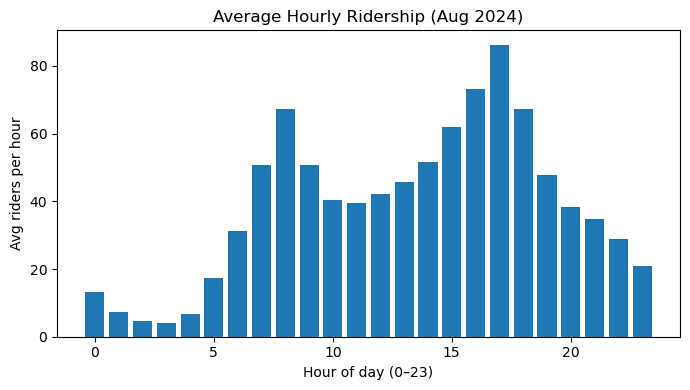

In [4]:
# STEP 4 — Average hourly profile (system-wide)

hourly_profile = (df_aug.groupby("hour", as_index=False)["ridership"]
                  .mean()
                  .rename(columns={"ridership":"avg_hourly_riders"}))

print(hourly_profile)

# Quick bar chart
plt.figure(figsize=(7,4))
plt.bar(hourly_profile["hour"], hourly_profile["avg_hourly_riders"])
plt.title("Average Hourly Ridership (Aug 2024)")
plt.xlabel("Hour of day (0–23)")
plt.ylabel("Avg riders per hour")
plt.tight_layout()
plt.show()

     label  avg_hourly_riders
0  Weekday          46.355993
1  Weekend          32.454570


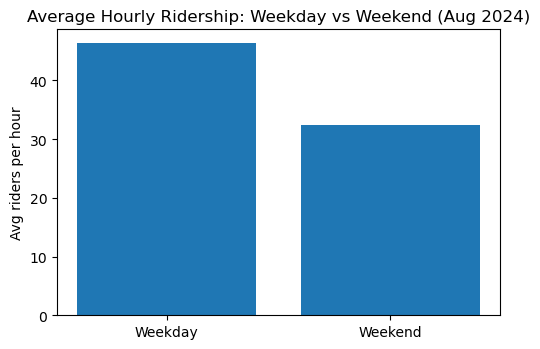

In [5]:
# STEP 5 — Weekday vs Weekend (system-wide)

# mark weekends
df_aug["is_weekend"] = df_aug["dow"].isin([5, 6])

# 5.1 average hourly ridership by weekend flag
wdwe = (df_aug.groupby("is_weekend", as_index=False)["ridership"]
        .mean()
        .rename(columns={"ridership":"avg_hourly_riders"}))
wdwe["label"] = wdwe["is_weekend"].map({False:"Weekday", True:"Weekend"})
print(wdwe[["label","avg_hourly_riders"]])

# 5.2 bar chart
plt.figure(figsize=(5.2,3.6))
plt.bar(wdwe["label"], wdwe["avg_hourly_riders"])
plt.title("Average Hourly Ridership: Weekday vs Weekend (Aug 2024)")
plt.ylabel("Avg riders per hour")
plt.tight_layout()
plt.show()

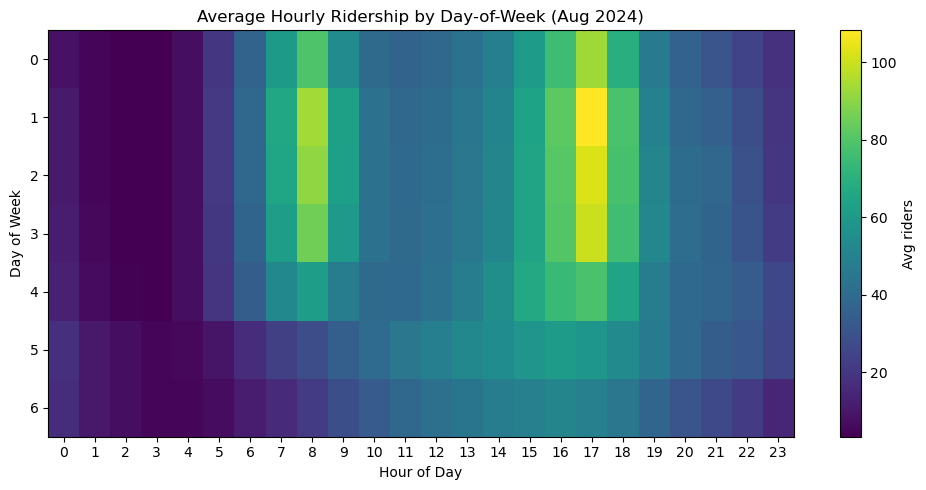

In [6]:
# STEP 6 — Heatmap: average ridership by day-of-week & hour

by_dow_hour = (df_aug.groupby(["dow_name","hour"], as_index=False)["ridership"]
               .mean()
               .rename(columns={"ridership":"avg_ridership"}))

# order days Mon→Sun
order = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
by_dow_hour["dow_name"] = pd.Categorical(by_dow_hour["dow_name"], categories=order, ordered=True)

# pivot to matrix
mat = by_dow_hour.pivot(index="dow_name", columns="hour", values="avg_ridership")

plt.figure(figsize=(10,5))
plt.imshow(mat, aspect="auto", interpolation="nearest")
plt.title("Average Hourly Ridership by Day-of-Week (Aug 2024)")
plt.xlabel("Hour of Day"); plt.ylabel("Day of Week")
plt.colorbar(label="Avg riders")
plt.xticks(range(24), range(24))
plt.tight_layout()
plt.show()

In [ ]:
he heatmap clearly shows the weekday AM (7–9) and PM (16–18) commute peaks, while weekends are flatter with a midday bump.

Mean: 2,944,637  Var: 588,435,983,041  Dispersion (Var/Mean): 199833.14
Estimated NB size parameter k: 14.735551194603387


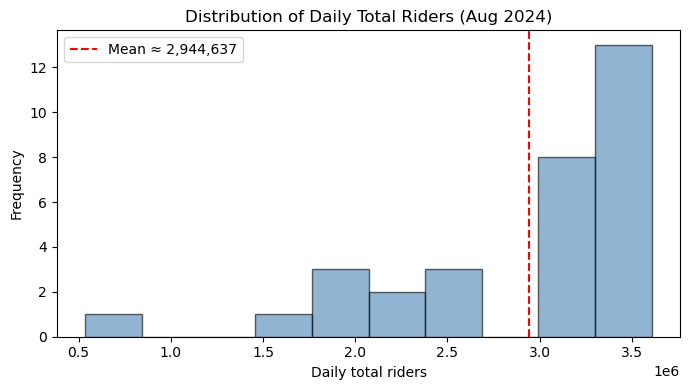

In [7]:
# STEP 7 — Distribution check on system daily totals

x = daily_totals["total_riders"].values
mu = x.mean()
var = x.var(ddof=1)
dispersion = var / mu
print(f"Mean: {mu:,.0f}  Var: {var:,.0f}  Dispersion (Var/Mean): {dispersion:.2f}")

# Method-of-moments Negative Binomial size param (k)
if var > mu:
    k = mu**2 / (var - mu)
else:
    k = np.inf
print("Estimated NB size parameter k:", k)

# Histogram + Poisson/NB overlays
plt.figure(figsize=(7,4))
plt.hist(x, bins=10, alpha=0.6, color="steelblue", edgecolor="black")
plt.axvline(mu, color="red", linestyle="--", label=f"Mean ≈ {mu:,.0f}")
plt.title("Distribution of Daily Total Riders (Aug 2024)")
plt.xlabel("Daily total riders"); plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()

##### Quick read of the outputs

###### Mean daily “floating population” proxy (system): ~2,944,637 riders/day (Aug 2024).

###### Distribution: variance ≫ mean (Var/Mean ≈ 199,833), NB size 𝑘 ≈ 14.7

###### k≈14.7 → strong over-dispersion, so Negative Binomial fits better than Poisson for daily totals.

###### Change patterns: weekdays are busier than weekends (46.36 vs 32.45 riders/hour on average), with clear AM (7–9) and PM (16–18) commute peaks; weekends flatter with a midday bump.

In [8]:
# STEP 8a — Per-station daily totals and mean

# 1) daily totals per station
daily_by_station = (df_aug.groupby(["station_complex","date"], as_index=False)["ridership"]
                    .sum()
                    .rename(columns={"ridership":"daily_riders"}))

print("daily_by_station shape:", daily_by_station.shape)
print(daily_by_station.head())

# 2) mean daily riders per station (your 'market' level if you pick a station/area)
mean_daily_by_station = (daily_by_station.groupby("station_complex", as_index=False)["daily_riders"]
                         .mean()
                         .rename(columns={"daily_riders":"mean_daily_riders"}))

# top 10 stations by mean daily riders in Aug
top10_station_mean = mean_daily_by_station.sort_values("mean_daily_riders", ascending=False).head(10)
print("\nTop 10 stations by mean daily riders (Aug 2024):")
print(top10_station_mean)

daily_by_station shape: (13224, 3)
  station_complex        date  daily_riders
0        1 Av (L)  2024-08-01         12584
1        1 Av (L)  2024-08-02         16984
2        1 Av (L)  2024-08-03         14672
3        1 Av (L)  2024-08-04         11514
4        1 Av (L)  2024-08-05         14299

Top 10 stations by mean daily riders (Aug 2024):
                                       station_complex  mean_daily_riders
402   Times Sq-42 St (N,Q,R,W,S,1,2,3,7)/42 St (A,C,E)      117716.612903
282                    Grand Central-42 St (S,4,5,6,7)       85272.096774
85                   34 St-Herald Sq (B,D,F,M,N,Q,R,W)       64162.903226
26                    14 St-Union Sq (L,N,Q,R,W,4,5,6)       55183.806452
276                        Fulton St (A,C,J,Z,2,3,4,5)       49833.903226
88                          34 St-Penn Station (A,C,E)       46307.967742
87                          34 St-Penn Station (1,2,3)       41600.290323
111                  59 St-Columbus Circle (A,B,C,D,1)     

In [9]:
# STEP 8b — Dispersion check per station

def station_dispersion(g):
    x = g["daily_riders"].values
    mu = x.mean()
    var = x.var(ddof=1)
    disp = var / mu if mu > 0 else np.nan
    k = mu**2 / (var - mu) if var > mu else np.inf
    model = "Poisson" if disp <= 1.25 else "NegBin"
    return pd.Series({"mean":mu, "var":var, "dispersion":disp, "nb_k":k, "model":model})

disp_tbl = daily_by_station.groupby("station_complex").apply(station_dispersion).reset_index()

# Top 10 busiest stations with their model choice
top_disp = disp_tbl.merge(mean_daily_by_station, on="station_complex") \
                   .sort_values("mean_daily_riders", ascending=False).head(10)

print(top_disp[["station_complex","mean_daily_riders","dispersion","model"]])

# Save full table
disp_tbl.to_csv(os.path.join(OUT_DIR, "station_dispersion_aug2024.csv"), index=False)
print("Saved: station_dispersion_aug2024.csv")


                                       station_complex  mean_daily_riders  \
402   Times Sq-42 St (N,Q,R,W,S,1,2,3,7)/42 St (A,C,E)      117716.612903   
282                    Grand Central-42 St (S,4,5,6,7)       85272.096774   
85                   34 St-Herald Sq (B,D,F,M,N,Q,R,W)       64162.903226   
26                    14 St-Union Sq (L,N,Q,R,W,4,5,6)       55183.806452   
276                        Fulton St (A,C,J,Z,2,3,4,5)       49833.903226   
88                          34 St-Penn Station (A,C,E)       46307.967742   
87                          34 St-Penn Station (1,2,3)       41600.290323   
111                  59 St-Columbus Circle (A,B,C,D,1)       39239.483871   
263                               Flushing-Main St (7)       39059.000000   
126  74-Broadway (7)/Jackson Hts-Roosevelt Av (E,F,...       38209.225806   

      dispersion   model  
402  6147.587976  NegBin  
282  9415.650389  NegBin  
85   3831.925749  NegBin  
26   3017.081148  NegBin  
276  4398.029009 

/var/folders/n4/8n2hpd_912g5cknmv3k37fjm0000gn/T/ipykernel_90031/1676087078.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  disp_tbl = daily_by_station.groupby("station_complex").apply(station_dispersion).reset_index()


In [11]:
# Rebuild weekly totals WITH station_complex_id so selection is robust
daily_by_station_id = (
    df_aug.groupby(["station_complex_id","station_complex","date"], as_index=False)["ridership"]
          .sum()
          .rename(columns={"ridership":"daily_riders"})
)

weekly_id = (
    daily_by_station_id
    .assign(week=pd.to_datetime(daily_by_station_id["date"]).dt.isocalendar().week.astype(int))
    .groupby(["station_complex_id","station_complex","week"], as_index=False)["daily_riders"]
    .sum()
    .rename(columns={"daily_riders":"weekly_riders"})
)

# WoW % within each station id
weekly_id["wow_change_pct"] = (
    weekly_id.groupby("station_complex_id")["weekly_riders"].pct_change() * 100
)

# Save full table
out_csv = os.path.join(OUT_DIR, "station_weekly_totals_wow_with_id.csv")
weekly_id.to_csv(out_csv, index=False)
print("Saved:", out_csv)

# (helper) show a few candidates you might want; edit the pattern if needed
pattern = r"Times|Grand Central|Penn|Union|Columbus|Flushing|Jackson|Roosevelt"
cands = weekly_id[weekly_id["station_complex"].str.contains(pattern, regex=True, na=False)] \
                 .drop_duplicates(subset=["station_complex_id","station_complex"]) \
                 .sort_values("station_complex").head(20)
print(cands[["station_complex_id","station_complex"]])


Saved: ./mta_aug2024_outputs/station_weekly_totals_wow_with_id.csv
     station_complex_id                                    station_complex
1785                602                   14 St-Union Sq (L,N,Q,R,W,4,5,6)
965                 318                         34 St-Penn Station (1,2,3)
260                 164                         34 St-Penn Station (A,C,E)
1850                614                  59 St-Columbus Circle (A,B,C,D,1)
1860                616  74-Broadway (7)/Jackson Hts-Roosevelt Av (E,F,...
1615                453                              82 St-Jackson Hts (7)
810                 287                                    Flushing Av (G)
2120                 98                                  Flushing Av (M,J)
1580                447                               Flushing-Main St (7)
1830                610                    Grand Central-42 St (S,4,5,6,7)
1510                433                                   Jackson Av (2,5)
685                 259          

                                       station_complex  week  weekly_riders  \
1835  Times Sq-42 St (N,Q,R,W,S,1,2,3,7)/42 St (A,C,E)    31         394244   
1836  Times Sq-42 St (N,Q,R,W,S,1,2,3,7)/42 St (A,C,E)    32         867338   
1837  Times Sq-42 St (N,Q,R,W,S,1,2,3,7)/42 St (A,C,E)    33         853792   
1838  Times Sq-42 St (N,Q,R,W,S,1,2,3,7)/42 St (A,C,E)    34         847235   
1839  Times Sq-42 St (N,Q,R,W,S,1,2,3,7)/42 St (A,C,E)    35         686606   

      wow_change_pct  
1835             NaN  
1836      120.000304  
1837       -1.561790  
1838       -0.767986  
1839      -18.959203  


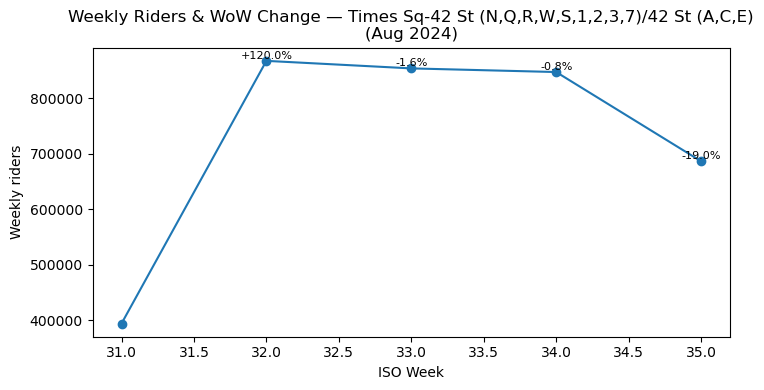

Saved plot: ./mta_aug2024_outputs/wow_station_611.png


In [13]:
# STEP 8d — Plot WoW (week-over-week plo) change for a chosen station id

SID = 611   # 👈 set this to the station_complex_id you want (e.g. 611 = Times Sq–42 St)

# Ensure consistent dtype (string) for IDs
weekly_id["station_complex_id"] = weekly_id["station_complex_id"].astype(str)

SID = "611"  # e.g., Times Sq–42 St from your list; use quotes now

s = weekly_id.loc[weekly_id["station_complex_id"] == SID].sort_values("week")
print(s[["station_complex","week","weekly_riders","wow_change_pct"]])

if s.empty:
    print("Still empty? Print a few rows to inspect types:")
    print(weekly_id.dtypes)
import matplotlib.pyplot as plt, os
OUT_DIR = "./mta_aug2024_outputs"

station_name = s["station_complex"].iloc[0]
plt.figure(figsize=(7.5,4))
plt.plot(s["week"], s["weekly_riders"], marker="o")
for w, y, pc in zip(s["week"], s["weekly_riders"], s["wow_change_pct"]):
    if not pd.isna(pc):
        plt.text(w, y, f"{pc:+.1f}%", fontsize=8, ha="center", va="bottom")
plt.title(f"Weekly Riders & WoW Change — {station_name}\n(Aug 2024)")
plt.xlabel("ISO Week"); plt.ylabel("Weekly riders")
plt.tight_layout()
outpng = os.path.join(OUT_DIR, f"wow_station_{SID}.png")
plt.savefig(outpng, dpi=160); plt.show()
print("Saved plot:", outpng)



In [14]:
# Top stations by total Aug riders WITH ids
top_with_id = (df_aug.groupby(["station_complex_id","station_complex"], as_index=False)["ridership"]
               .sum().sort_values("ridership", ascending=False).head(20))
top_with_id["station_complex_id"] = top_with_id["station_complex_id"].astype(str)
print(top_with_id)

    station_complex_id                                    station_complex  \
367                611   Times Sq-42 St (N,Q,R,W,S,1,2,3,7)/42 St (A,C,E)   
366                610                    Grand Central-42 St (S,4,5,6,7)   
362                607                  34 St-Herald Sq (B,D,F,M,N,Q,R,W)   
357                602                   14 St-Union Sq (L,N,Q,R,W,4,5,6)   
385                628                        Fulton St (A,C,J,Z,2,3,4,5)   
52                 164                         34 St-Penn Station (A,C,E)   
193                318                         34 St-Penn Station (1,2,3)   
370                614                  59 St-Columbus Circle (A,B,C,D,1)   
316                447                               Flushing-Main St (7)   
372                616  74-Broadway (7)/Jackson Hts-Roosevelt Av (E,F,...   
381                624  Chambers St (A,C)/WTC (E)/Park Pl (2,3)/Cortla...   
109                225                47-50 Sts-Rockefeller Ctr (B,D,F,M)   

In [15]:
# STEP 9a — Choose stations to analyze (IDs as strings)
SIDS = ["611",  # Times Sq–42 St
        "610",  # Grand Central–42 St
        "607",  # 34 St–Herald Sq
        "616",  # 74–Broadway/Jackson Hts–Roosevelt Av
        "447"]  # Flushing–Main St

# keep only August rows for these IDs
sub = df_aug[df_aug["station_complex_id"].astype(str).isin(SIDS)].copy()
sub.shape

(32761, 17)

In [16]:
# STEP 9b — Daily totals per station + summary stats
import os, numpy as np, pandas as pd

OUT_DIR = "./mta_aug2024_outputs"

daily_by_sid = (sub.groupby(["station_complex_id","station_complex","date"], as_index=False)["ridership"]
                  .sum()
                  .rename(columns={"ridership":"daily_riders"}))

def summarize(g):
    x = g["daily_riders"].values
    mu = x.mean(); med = np.median(x)
    var = x.var(ddof=1) if x.size>1 else np.nan
    disp = var/mu if mu>0 and var==var else np.nan
    k = (mu**2)/(var - mu) if (var>mu) else np.inf  # NB size (MoM)
    model = "NegBin" if (disp is not np.nan and disp>1.25) else "Poisson"
    return pd.Series(dict(mean_daily=mu, median_daily=med, var=var, dispersion=disp, nb_k=k, model=model))

station_summary = (daily_by_sid.groupby(["station_complex_id","station_complex"])
                   .apply(summarize).reset_index())
station_summary.to_csv(os.path.join(OUT_DIR, "station_summary_mean_dist_aug2024.csv"), index=False)
station_summary


/var/folders/n4/8n2hpd_912g5cknmv3k37fjm0000gn/T/ipykernel_90031/4245151625.py:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(summarize).reset_index())


,station_complex_id,station_complex,mean_daily,median_daily,var,dispersion,nb_k,model
0,447,Flushing-Main St (7),39059.000000,43235.0,7.962853e+07,2038.673072,19.168433,NegBin
1,607,"34 St-Herald Sq (B,D,F,M,N,Q,R,W)",64162.903226,69264.0,2.458675e+08,3831.925749,16.748668,NegBin
2,610,"Grand Central-42 St (S,4,5,6,7)",85272.096774,94032.0,8.028923e+08,9415.650389,9.057383,NegBin
3,611,"Times Sq-42 St (N,Q,R,W,S,1,2,3,7)/42 St (A,C,E)",117716.612903,124192.0,7.236732e+08,6147.587976,19.151538,NegBin
4,616,"74-Broadway (7)/Jackson Hts-Roosevelt Av (E,F,...",38209.225806,42116.0,7.491262e+07,1960.589791,19.498584,NegBin


In [17]:
# STEP 9c — Hourly profile split by weekday/weekend (saved)
import matplotlib.pyplot as plt

sub["is_weekend"] = sub["dow"].isin([5,6])
for sid, g in sub.groupby("station_complex_id"):
    name = g["station_complex"].iloc[0]
    prof = (g.groupby(["is_weekend","hour"], as_index=False)["ridership"]
            .mean().rename(columns={"ridership":"avg_hourly"}))
    # order
    prof_wd  = prof[prof["is_weekend"]==False]
    prof_we  = prof[prof["is_weekend"]==True]

    plt.figure(figsize=(7.5,4))
    plt.plot(prof_wd["hour"], prof_wd["avg_hourly"], marker="o", label="Weekday")
    plt.plot(prof_we["hour"], prof_we["avg_hourly"], marker="o", label="Weekend")
    plt.title(f"Hourly Profile — {name} (Aug 2024)")
    plt.xlabel("Hour (0–23)"); plt.ylabel("Avg riders/hour"); plt.legend()
    plt.tight_layout()
    outpng = os.path.join(OUT_DIR, f"profile_hourly_sid{sid}.png")
    plt.savefig(outpng, dpi=160); plt.close()
    print("Saved:", outpng)


Saved: ./mta_aug2024_outputs/profile_hourly_sid447.png
Saved: ./mta_aug2024_outputs/profile_hourly_sid607.png
Saved: ./mta_aug2024_outputs/profile_hourly_sid610.png
Saved: ./mta_aug2024_outputs/profile_hourly_sid611.png
Saved: ./mta_aug2024_outputs/profile_hourly_sid616.png


In [18]:
# STEP 9d — Daily total plot + 7d rolling; and histogram (two PNGs per station)
for sid, g in daily_by_sid.groupby("station_complex_id"):
    name = g["station_complex"].iloc[0]
    gg = g.sort_values("date").copy()
    gg["date_dt"] = pd.to_datetime(gg["date"])
    gg["roll7"] = gg["daily_riders"].rolling(7, min_periods=1).mean()

    # time series
    import matplotlib.pyplot as plt, numpy as np
    plt.figure(figsize=(8,4))
    plt.plot(gg["date_dt"], gg["daily_riders"], marker="o", linewidth=1)
    plt.plot(gg["date_dt"], gg["roll7"], linewidth=2)
    plt.title(f"Daily Riders (+7d mean) — {name} (Aug 2024)")
    plt.xlabel("Date"); plt.ylabel("Riders"); plt.xticks(rotation=45)
    plt.tight_layout()
    out1 = os.path.join(OUT_DIR, f"daily_ts_sid{sid}.png")
    plt.savefig(out1, dpi=160); plt.close()
    print("Saved:", out1)

    # histogram + NB/Poisson hint
    x = gg["daily_riders"].values
    mu = x.mean(); var = x.var(ddof=1) if x.size>1 else np.nan
    disp = var/mu if mu>0 and var==var else np.nan
    k = (mu**2)/(var - mu) if (var>mu) else np.inf
    model = "NegBin" if (disp is not np.nan and disp>1.25) else "Poisson"

    plt.figure(figsize=(7,4))
    plt.hist(x, bins=8, edgecolor="black", alpha=0.7)
    plt.axvline(mu, linestyle="--", label=f"Mean ≈ {mu:,.0f}")
    plt.title(f"Daily Riders Histogram — {name}\nModel: {model}  (disp≈{disp:.1f}, k≈{k:.1f})")
    plt.xlabel("Daily riders"); plt.ylabel("Days")
    plt.legend(); plt.tight_layout()
    out2 = os.path.join(OUT_DIR, f"hist_sid{sid}.png")
    plt.savefig(out2, dpi=160); plt.close()
    print("Saved:", out2)


Saved: ./mta_aug2024_outputs/daily_ts_sid447.png
Saved: ./mta_aug2024_outputs/hist_sid447.png
Saved: ./mta_aug2024_outputs/daily_ts_sid607.png
Saved: ./mta_aug2024_outputs/hist_sid607.png
Saved: ./mta_aug2024_outputs/daily_ts_sid610.png
Saved: ./mta_aug2024_outputs/hist_sid610.png
Saved: ./mta_aug2024_outputs/daily_ts_sid611.png
Saved: ./mta_aug2024_outputs/hist_sid611.png
Saved: ./mta_aug2024_outputs/daily_ts_sid616.png
Saved: ./mta_aug2024_outputs/hist_sid616.png


In [ ]:
from IPython.display import Image, display

paths = [
"./mta_aug2024_outputs/daily_ts_sid447.png",
"./mta_aug2024_outputs/hist_sid447.png",
"./mta_aug2024_outputs/daily_ts_sid607.png",
"./mta_aug2024_outputs/hist_sid607.png",
"./mta_aug2024_outputs/daily_ts_sid610.png",
"./mta_aug2024_outputs/hist_sid610.png",
"./mta_aug2024_outputs/daily_ts_sid611.png",
"./mta_aug2024_outputs/hist_sid611.png",
"./mta_aug2024_outputs/daily_ts_sid616.png",
"./mta_aug2024_outputs/hist_sid616.png
]

for p in paths:
    display(Image(filename=p, width=900))  # tweak width if you like


In [19]:
# STEP 9e — WoW chart per station (saved)
weekly_id["station_complex_id"] = weekly_id["station_complex_id"].astype(str)

for sid in SIDS:
    s = weekly_id.loc[weekly_id["station_complex_id"] == sid].sort_values("week")
    if s.empty:
        print("No weekly rows for", sid); continue
    name = s["station_complex"].iloc[0]

    import matplotlib.pyplot as plt
    plt.figure(figsize=(7.5,4))
    plt.plot(s["week"], s["weekly_riders"], marker="o")
    for w, y, pc in zip(s["week"], s["weekly_riders"], s["wow_change_pct"]):
        if not pd.isna(pc):
            plt.text(w, y, f"{pc:+.1f}%", fontsize=8, ha="center", va="bottom")
    plt.title(f"Weekly Riders & WoW — {name} (Aug 2024)")
    plt.xlabel("ISO Week"); plt.ylabel("Weekly riders")
    plt.tight_layout()
    outpng = os.path.join(OUT_DIR, f"wow_sid{sid}.png")
    plt.savefig(outpng, dpi=160); plt.close()
    print("Saved:", outpng)


Saved: ./mta_aug2024_outputs/wow_sid611.png
Saved: ./mta_aug2024_outputs/wow_sid610.png
Saved: ./mta_aug2024_outputs/wow_sid607.png
Saved: ./mta_aug2024_outputs/wow_sid616.png
Saved: ./mta_aug2024_outputs/wow_sid447.png


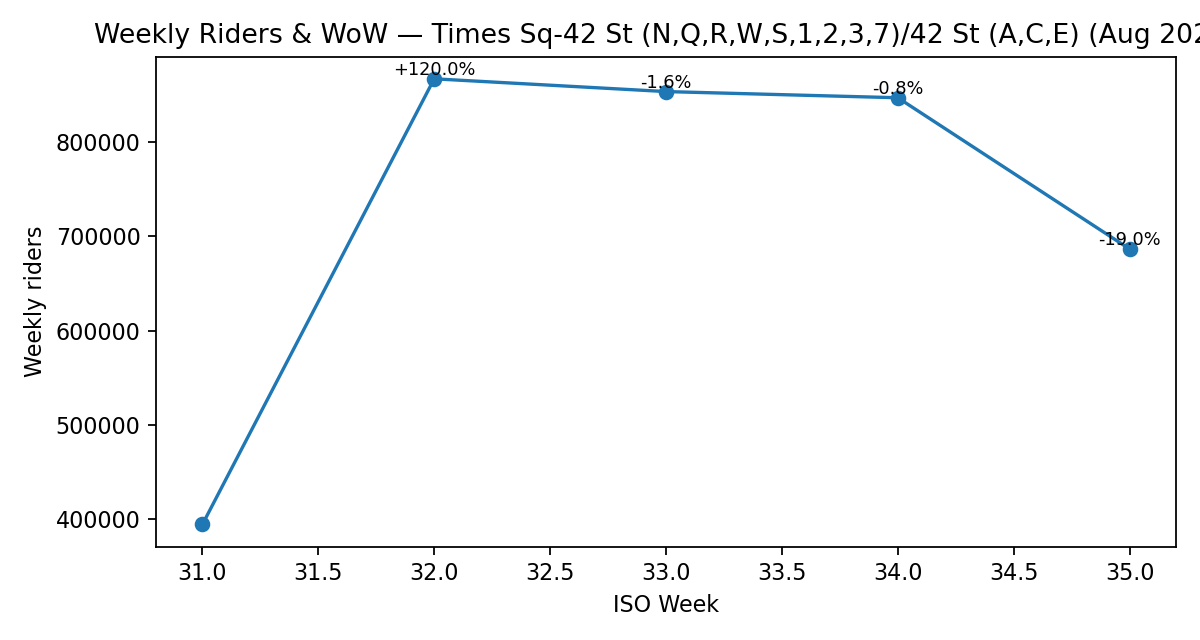

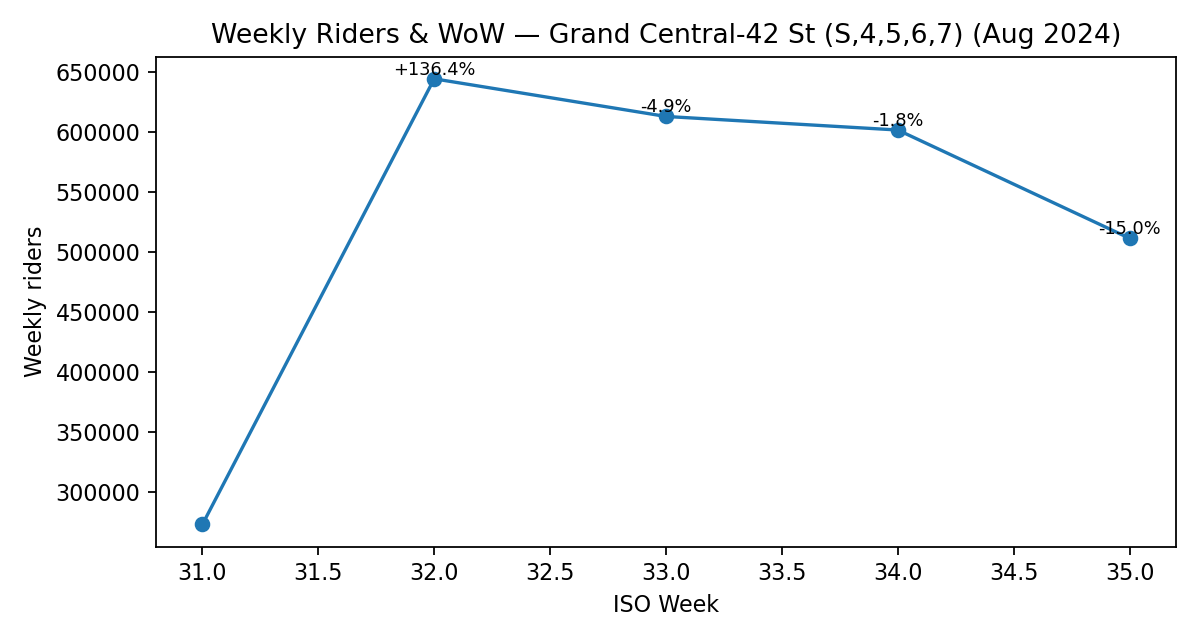

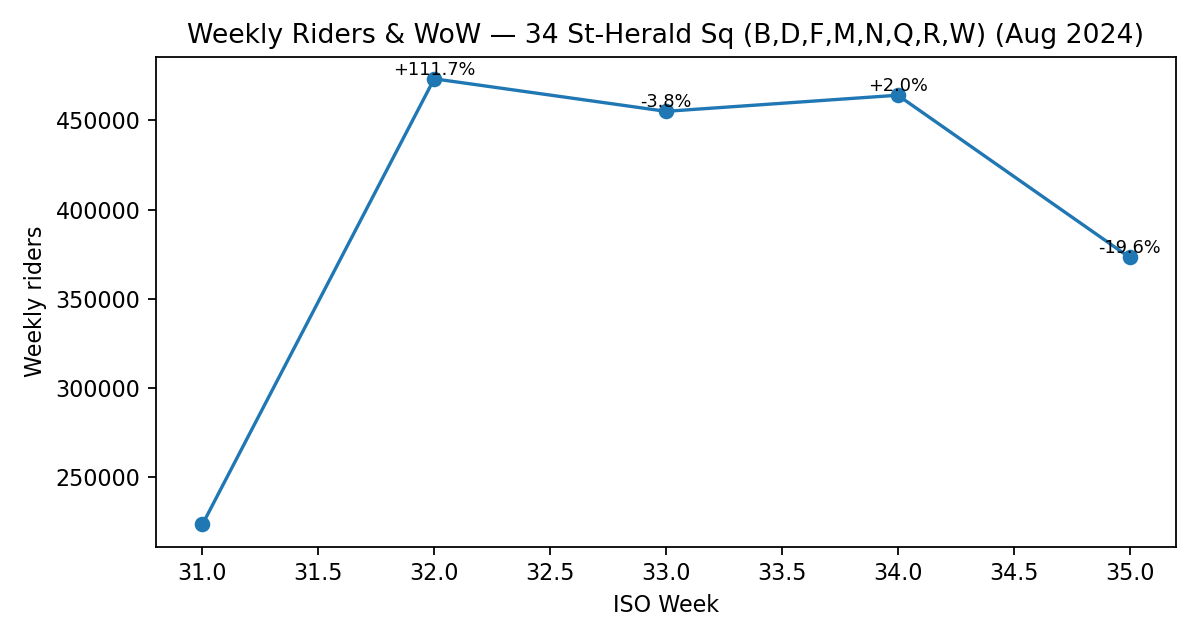

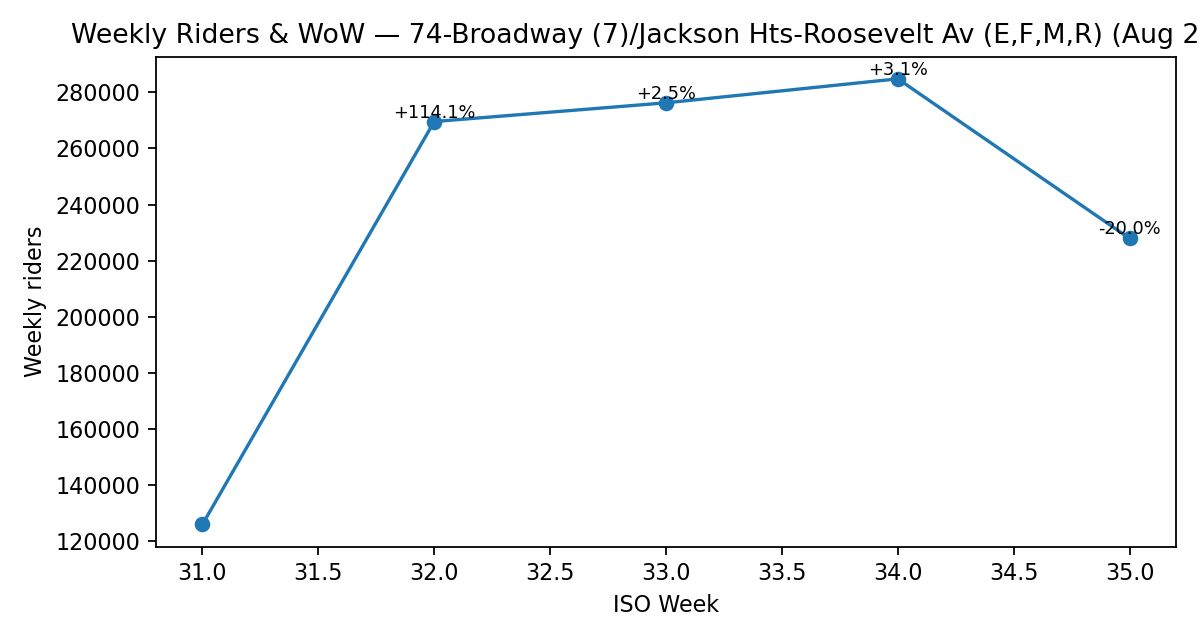

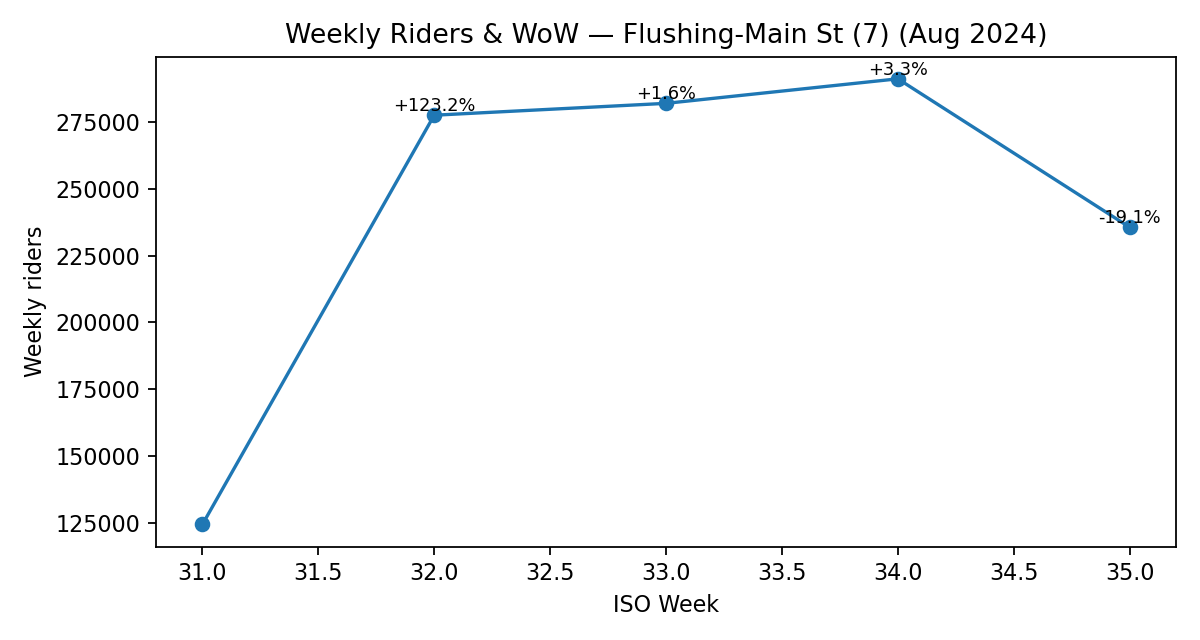

In [31]:
from IPython.display import Image, display

paths = [
    "./mta_aug2024_outputs/wow_sid611.png",
    "./mta_aug2024_outputs/wow_sid610.png",
    "./mta_aug2024_outputs/wow_sid607.png",
    "./mta_aug2024_outputs/wow_sid616.png",
    "./mta_aug2024_outputs/wow_sid447.png",
]

for p in paths:
    display(Image(filename=p, width=900))  # tweak width if you like


# SUMMARY

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

OUT_DIR = "./mta_aug2024_outputs"
os.makedirs(OUT_DIR, exist_ok=True)

# ---------- data prep (minimal, fast) ----------
SIDS = ["611","610","607","447","609"]
sub = df_aug[df_aug["station_complex_id"].astype(str).isin(SIDS)].copy()

# 1) DAILY TOTALS PER STATION + SUMMARY (table)
daily_by_sid = (sub.groupby(["station_complex_id","station_complex","date"], as_index=False)["ridership"]
                  .sum().rename(columns={"ridership":"daily_riders"}))

def summarize(g):
    x = g["daily_riders"].values
    mu = x.mean(); med = np.median(x)
    var = x.var(ddof=1) if x.size>1 else np.nan
    disp = (var/mu) if (mu>0 and var==var) else np.nan
    k = (mu**2)/(var - mu) if (var>mu) else np.inf
    model = "NegBin" if (disp is not np.nan and disp>1.25) else "Poisson"
    return pd.Series(dict(mean_daily=mu, median_daily=med, variance=var,
                          dispersion=disp, nb_k=k, model=model))

station_summary = (daily_by_sid.groupby(["station_complex_id","station_complex"])
                   .apply(summarize).reset_index())

# Save nice rounded CSV for the report
cols = ["station_complex_id","station_complex","mean_daily","median_daily","dispersion","nb_k","model"]
station_summary_out = station_summary[cols].copy()
station_summary_out[["mean_daily","median_daily","dispersion","nb_k"]] = \
    station_summary_out[["mean_daily","median_daily","dispersion","nb_k"]].round(1)
station_summary_out.to_csv(os.path.join(OUT_DIR, "station_summary_mean_dist_aug2024.csv"), index=False)
station_summary_out

/var/folders/n4/8n2hpd_912g5cknmv3k37fjm0000gn/T/ipykernel_90031/412172963.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(summarize).reset_index())


,station_complex_id,station_complex,mean_daily,median_daily,dispersion,nb_k,model
0,447,Flushing-Main St (7),39059.0,43235.0,2038.7,19.2,NegBin
1,607,"34 St-Herald Sq (B,D,F,M,N,Q,R,W)",64162.9,69264.0,3831.9,16.7,NegBin
2,609,"Bryant Pk (B,D,F,M)/5 Av (7)",31173.7,33929.0,3759.9,8.3,NegBin
3,610,"Grand Central-42 St (S,4,5,6,7)",85272.1,94032.0,9415.7,9.1,NegBin
4,611,"Times Sq-42 St (N,Q,R,W,S,1,2,3,7)/42 St (A,C,E)",117716.6,124192.0,6147.6,19.2,NegBin


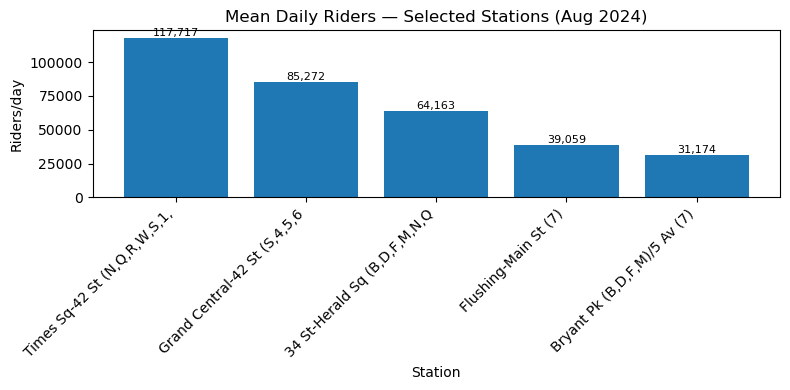

In [26]:
# Mean daily riders bar
order = station_summary.sort_values("mean_daily", ascending=False)
plt.figure(figsize=(8,4))
plt.bar(order["station_complex"].str.slice(0,28), order["mean_daily"])
plt.title("Mean Daily Riders — Selected Stations (Aug 2024)")
plt.xlabel("Station"); plt.ylabel("Riders/day")
plt.xticks(rotation=45, ha="right")
for i,(x,y) in enumerate(zip(order["station_complex"].str.slice(0,28), order["mean_daily"])):
    plt.text(i, y, f"{y:,.0f}", ha="center", va="bottom", fontsize=8)
save_and_show(os.path.join(OUT_DIR, "mean_daily_by_station.png"))


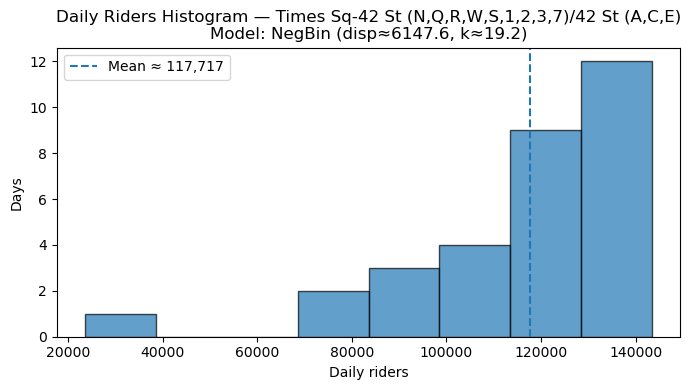

In [27]:
# Histogram for one target station (pick the one you care about most)
TARGET = "611"  # e.g., Times Sq–42 St
g = daily_by_sid.loc[daily_by_sid["station_complex_id"]==TARGET].copy()
name = g["station_complex"].iloc[0]
x = g["daily_riders"].values
mu = x.mean(); var = x.var(ddof=1); disp = var/mu if mu>0 else np.nan
k = (mu**2)/(var - mu) if var>mu else np.inf
model = "NegBin" if disp>1.25 else "Poisson"

plt.figure(figsize=(7,4))
plt.hist(x, bins=8, edgecolor="black", alpha=0.7)
plt.axvline(mu, linestyle="--", label=f"Mean ≈ {mu:,.0f}")
plt.title(f"Daily Riders Histogram — {name}\nModel: {model} (disp≈{disp:.1f}, k≈{k:.1f})")
plt.xlabel("Daily riders"); plt.ylabel("Days"); plt.legend()
save_and_show(os.path.join(OUT_DIR, f"hist_station_{TARGET}.png"))


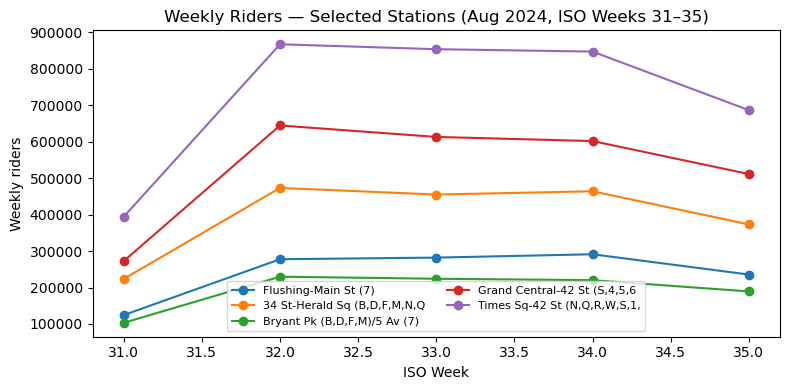

In [28]:
weekly = (daily_by_sid.assign(week=pd.to_datetime(daily_by_sid["date"]).dt.isocalendar().week.astype(int))
          .groupby(["station_complex_id","station_complex","week"], as_index=False)["daily_riders"]
          .sum().rename(columns={"daily_riders":"weekly_riders"}))

plt.figure(figsize=(8,4))
for sid, grp in weekly.groupby("station_complex_id"):
    nm = grp["station_complex"].iloc[0]
    gg = grp.sort_values("week")
    plt.plot(gg["week"], gg["weekly_riders"], marker="o", label=nm[:28])
plt.title("Weekly Riders — Selected Stations (Aug 2024, ISO Weeks 31–35)")
plt.xlabel("ISO Week"); plt.ylabel("Weekly riders")
plt.legend(ncol=2, fontsize=8)
save_and_show(os.path.join(OUT_DIR, "weekly_riders_selected.png"))


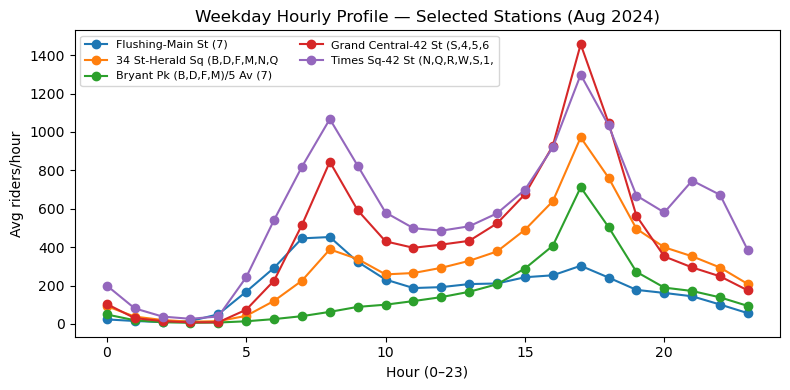

In [29]:
sub["is_weekend"] = sub["dow"].isin([5,6])
weekday = sub[sub["is_weekend"]==False]
prof = (weekday.groupby(["station_complex_id","station_complex","hour"], as_index=False)["ridership"]
        .mean().rename(columns={"ridership":"avg_hourly"}))

plt.figure(figsize=(8,4))
for sid, grp in prof.groupby("station_complex_id"):
    nm = grp["station_complex"].iloc[0]
    gg = grp.sort_values("hour")
    plt.plot(gg["hour"], gg["avg_hourly"], marker="o", label=nm[:28])
plt.title("Weekday Hourly Profile — Selected Stations (Aug 2024)")
plt.xlabel("Hour (0–23)"); plt.ylabel("Avg riders/hour")
plt.legend(ncol=2, fontsize=8)
save_and_show(os.path.join(OUT_DIR, "weekday_hourly_profile_selected.png"))
